####======================================================
### **Final Project**
### Saurav Luthra, 55027009
### **ECE 648 - Machine Learning**
####======================================================

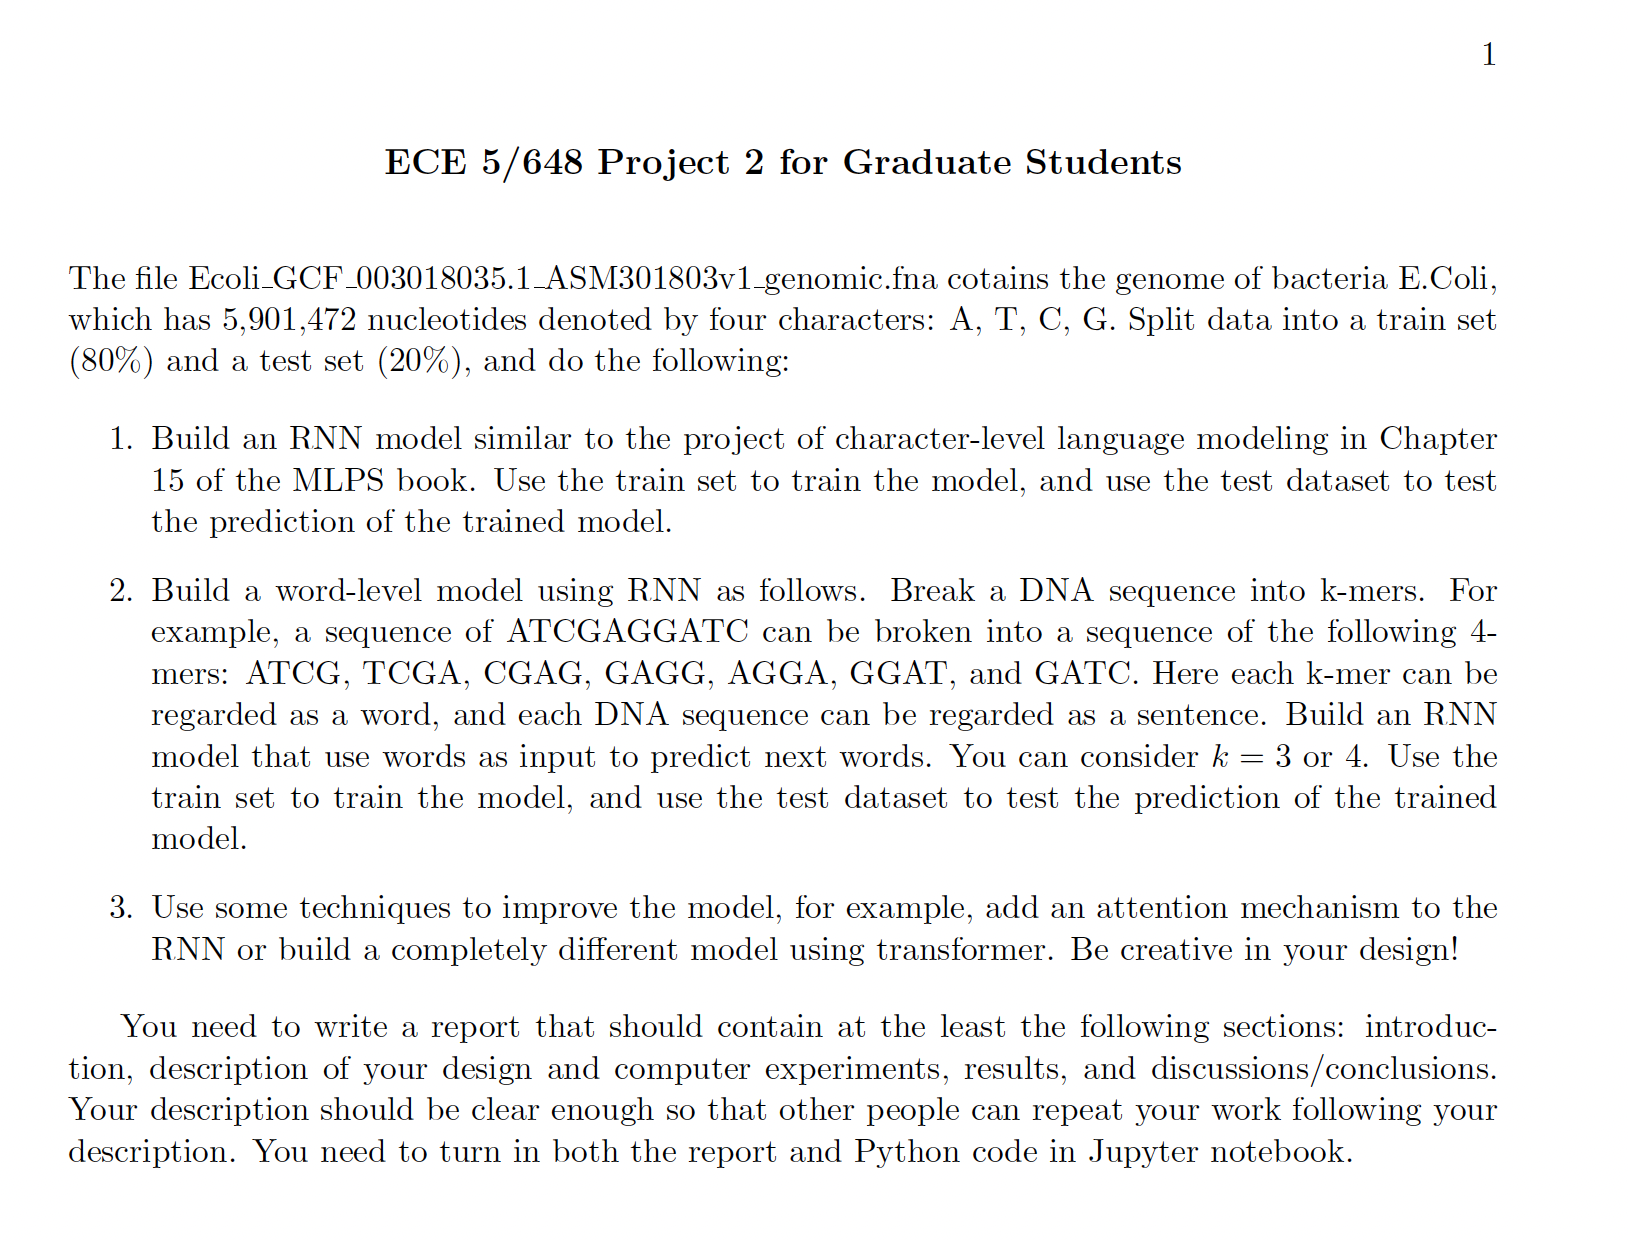

#### ====================================================
#### LOAD DATA
#### ======================================================

In [1]:
# do all library imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
# setting up the drive access for Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# load the full_sequence from the file
directory = '/content/drive/My Drive/ECE648_project/'
file_name = 'Ecoli_GCF_003018035.1_ASM301803v1_genomic.fna'

file_path = directory + file_name

sequence = []
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('>'):
            # Skip headers
            continue
        # Add line to list, stripped of whitespace
        sequence.append(line.strip())

# Join all lines into one big string
full_sequence = ''.join(sequence)

print(f"Sequence length: {len(full_sequence):,}")


Sequence length: 5,901,472


In [4]:
full_sequence[:50]

'TGCTCTCTTTACCGCTGTTTCACGTCTCCGGTCAGGGAATTATGTGGCGC'

In [5]:
# custom class for textdataset - text_chunks should be ENCODED as ints
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    # takes text_chunks of seq_length + 1 and returns the input, target pair
    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()

In [6]:
# set device to GPU if available, otherwise CPU
if torch.cuda.is_available():
  print(f"GPU available: {torch.cuda.get_device_name(0)}")
  device = torch.device("cuda:0")
else:
  print("No GPU available")
  device = 'cpu'

GPU available: NVIDIA L4


###RNN Class for Question 1 and Question 2

In [14]:
# define the RNN class
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)

#### ====================================================
#### QUESTION 1
#### ======================================================

In [8]:
# encode the full sequence into ints, 1 character at a time
char_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
char_array = np.array(list(char_map.keys()))

text_encoded = [char_map[char] for char in full_sequence]

In [17]:
# chosen length of sequence
seq_length = 200
chunk_size = seq_length + 1

In [18]:
# get all the text_chunks of length chunk_size
text_chunks = [text_encoded[ i : i + chunk_size] for i in range(len(text_encoded) - chunk_size + 1)]

In [19]:
# split all the chunks in a training and test set of chunks
train_chunks, test_chunks = train_test_split(text_chunks, test_size=0.2, random_state=305)

train_chunks = TextDataset(torch.tensor(train_chunks))
test_chunks = TextDataset(torch.tensor(test_chunks))

In [20]:
# set batch_size = 512, and use DataLoader to set up the data in batches to train the neural network
batch_size = 512

torch.manual_seed(305)
train_dl = DataLoader(train_chunks, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_chunks, batch_size=batch_size, drop_last=True)

In [21]:
vocab_size = len(char_array)
embed_dim = 128
rnn_hidden_size = 1024

torch.manual_seed(1)
model1 = RNN(vocab_size, embed_dim, rnn_hidden_size)
model1 = model1.to(device)
model1

RNN(
  (embedding): Embedding(4, 128)
  (rnn): LSTM(128, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=4, bias=True)
)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

num_epochs = 10000

torch.manual_seed(1)

for epoch in range(num_epochs):

    hidden, cell = model1.init_hidden(batch_size)

    seq_batch, target_batch = next(iter(train_dl))

    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)

    optimizer.zero_grad()
    loss = 0

    for c in range(seq_length):
        pred, hidden, cell = model1(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])

    loss.backward()
    optimizer.step()

    loss = loss.item()/seq_length
    if epoch % 250 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')


Epoch 0 loss: 1.3193
Epoch 250 loss: 1.2995
Epoch 500 loss: 1.2878
Epoch 750 loss: 1.2694
Epoch 1000 loss: 1.2570
Epoch 1250 loss: 1.2156
Epoch 1500 loss: 1.1763
Epoch 1750 loss: 1.1451
Epoch 2000 loss: 1.1174
Epoch 2250 loss: 1.0671
Epoch 2500 loss: 1.0462
Epoch 2750 loss: 1.0268
Epoch 3000 loss: 1.0189
Epoch 3250 loss: 0.9842
Epoch 3500 loss: 0.9580
Epoch 3750 loss: 0.9419
Epoch 4000 loss: 0.9628
Epoch 4250 loss: 0.9152
Epoch 4500 loss: 0.9271
Epoch 4750 loss: 0.9148
Epoch 5000 loss: 0.8980
Epoch 5250 loss: 0.9017
Epoch 5500 loss: 0.9030
Epoch 5750 loss: 0.8875
Epoch 6000 loss: 0.8804
Epoch 6250 loss: 0.8740
Epoch 6500 loss: 0.8723
Epoch 6750 loss: 0.8688
Epoch 7000 loss: 0.8564
Epoch 7250 loss: 0.8437
Epoch 7500 loss: 0.8514
Epoch 7750 loss: 0.8506
Epoch 8000 loss: 0.8414
Epoch 8250 loss: 0.8363
Epoch 8500 loss: 0.8410
Epoch 8750 loss: 0.8335
Epoch 9000 loss: 0.8256
Epoch 9250 loss: 0.8208
Epoch 9500 loss: 0.8289
Epoch 9750 loss: 0.8062


In [26]:
# Save the model's state dictionary
torch.save(model1.state_dict(), '/content/drive/My Drive/ECE648_project/ece648_final_project_model1.pth')

In [27]:
# Set model to evaluation mode
model1.eval()

correct = 0
total = 0

# don't compute gradients during evaluation
with torch.no_grad():
    for seq_batch, target_batch in test_dl:
        seq_batch = seq_batch.to(device)
        target_batch = target_batch.to(device)

        hidden, cell = model1.init_hidden(batch_size)  # Re-initialize hidden states

        # We accumulate the total number of correct predictions across the entire dataset
        for c in range(seq_length):
            pred, hidden, cell = model1(seq_batch[:, c], hidden, cell)

            # The predictions are logits, so we apply argmax to get the most likely class
            predicted = torch.argmax(pred, dim=1)  # Get the index of max logit for each prediction

            # Calculate the number of correct predictions
            correct += (predicted == target_batch[:, c]).sum().item()
            total += target_batch.size(0)  # Update total number of elements

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.4f}%')


Accuracy on test dataset: 66.1203%


#### ====================================================
#### QUESTION 2
#### ======================================================

In [7]:
def generate_kmers(sequence, k=4):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def kmer_to_int(kmer):
  mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
  value = 0
  for char in kmer:
      value = value * 4 + mapping[char]
  return value

def int_to_kmer(idx, k=4):
  idx -= 1  # reverse 1-indexing
  chars = ['A', 'C', 'G', 'T']
  kmer = ""
  for _ in range(k):
      kmer = chars[idx % 4] + kmer
      idx //= 4
  return kmer

In [8]:
kmers = generate_kmers(full_sequence, k=4)
print(kmers[:10])

['TGCT', 'GCTC', 'CTCT', 'TCTC', 'CTCT', 'TCTT', 'CTTT', 'TTTA', 'TTAC', 'TACC']


In [9]:
kmers_encoded = [kmer_to_int(kmer) for kmer in kmers]
print(kmers_encoded[:10])

[231, 157, 119, 221, 119, 223, 127, 252, 241, 197]


In [10]:
len(kmers_encoded)

5901469

In [11]:
kmers_set = list(set(kmers_encoded))

In [12]:
kmer_seq_length = 200
kmer_chunk_size = kmer_seq_length + 1

In [13]:
# get all the text_chunks of length chunk_size
kmer_chunks = [kmers_encoded[ i : i + kmer_chunk_size] for i in range(len(kmers_encoded) - kmer_chunk_size + 1)]

In [14]:
# split all the chunks in a training and test set of chunks
kmer_train_chunks, kmer_test_chunks = train_test_split(kmer_chunks, test_size=0.2, random_state=305)

kmer_train_chunks = TextDataset(torch.tensor(kmer_train_chunks))
kmer_test_chunks = TextDataset(torch.tensor(kmer_test_chunks))

In [19]:
# set batch_size, and use DataLoader to set up the data in batches to train the neural network
batch_size = 512

torch.manual_seed(305)
kmer_train_dl = DataLoader(kmer_train_chunks, batch_size=batch_size, shuffle=True, drop_last=True)
kmer_test_dl = DataLoader(kmer_test_chunks, batch_size=batch_size, drop_last=True)

In [45]:
vocab_size = len(kmers_set)
embed_dim = 512
rnn_hidden_size = 1024

torch.manual_seed(1)
model2 = RNN(vocab_size, embed_dim, rnn_hidden_size)
model2 = model2.to(device)
model2

RNN(
  (embedding): Embedding(256, 512)
  (rnn): LSTM(512, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=256, bias=True)
)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

num_epochs = 15000

torch.manual_seed(1)

for epoch in range(num_epochs):

    hidden, cell = model2.init_hidden(batch_size)

    seq_batch, target_batch = next(iter(kmer_train_dl))

    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)

    optimizer.zero_grad()
    loss = 0

    for c in range(kmer_seq_length):
        pred, hidden, cell = model2(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])

    loss.backward()
    optimizer.step()

    loss = loss.item()/kmer_seq_length
    if epoch % 250 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')


Epoch 0 loss: 5.5444
Epoch 250 loss: 1.3419
Epoch 500 loss: 1.3314
Epoch 750 loss: 1.3159
Epoch 1000 loss: 1.2846
Epoch 1250 loss: 1.2471
Epoch 1500 loss: 1.2003
Epoch 1750 loss: 1.1577
Epoch 2000 loss: 1.0898
Epoch 2250 loss: 1.0315
Epoch 2500 loss: 1.0074
Epoch 2750 loss: 0.9741
Epoch 3000 loss: 0.9321
Epoch 3250 loss: 0.9226
Epoch 3500 loss: 0.8866
Epoch 3750 loss: 0.8651
Epoch 4000 loss: 0.8405
Epoch 4250 loss: 0.8317
Epoch 4500 loss: 0.8170
Epoch 4750 loss: 0.8111
Epoch 5000 loss: 0.8030
Epoch 5250 loss: 0.7871
Epoch 5500 loss: 0.7752
Epoch 5750 loss: 0.7528
Epoch 6000 loss: 0.7455
Epoch 6250 loss: 0.7506
Epoch 6500 loss: 0.7262
Epoch 6750 loss: 0.7308
Epoch 7000 loss: 0.7125
Epoch 7250 loss: 0.7038
Epoch 7500 loss: 0.7045
Epoch 7750 loss: 0.6984
Epoch 8000 loss: 0.7041
Epoch 8250 loss: 0.6905
Epoch 8500 loss: 0.6816
Epoch 8750 loss: 0.6600
Epoch 9000 loss: 0.6658
Epoch 9250 loss: 0.6632
Epoch 9500 loss: 0.6490
Epoch 9750 loss: 0.6466
Epoch 10000 loss: 0.6446
Epoch 10250 loss: 0.6

In [47]:
# Save the model's state dictionary
torch.save(model2.state_dict(), '/content/drive/My Drive/ECE648_project/ece648_final_project_model2.pth')

In [48]:
# Set model to evaluation mode
model2.eval()

correct = 0
total = 0

# don't compute gradients during evaluation
with torch.no_grad():
    for seq_batch, target_batch in kmer_test_dl:
        seq_batch = seq_batch.to(device)
        target_batch = target_batch.to(device)

        hidden, cell = model2.init_hidden(batch_size)  # Re-initialize hidden states

        # We accumulate the total number of correct predictions across the entire dataset
        for c in range(kmer_seq_length):
            pred, hidden, cell = model2(seq_batch[:, c], hidden, cell)

            # The predictions are logits, so we apply argmax to get the most likely class
            predicted = torch.argmax(pred, dim=1)  # Get the index of max logit for each prediction

            # Calculate the number of correct predictions
            correct += (predicted == target_batch[:, c]).sum().item()
            total += target_batch.size(0)  # Update total number of elements

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.4f}%')


Accuracy on test dataset: 77.9619%


#### ====================================================
#### QUESTION 3
#### ======================================================

In [15]:
class RNN3(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, num_layers=3, dropout_prob=0.5):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Increase the number of hidden units (nodes) and LSTM layers
        self.rnn_hidden_size = rnn_hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # LSTM with multiple layers and dropout
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers=num_layers,
                           batch_first=True, dropout=dropout_prob)

        # Fully connected output layer
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        # Pass the input through the embedding layer
        out = self.embedding(x).unsqueeze(1)

        # Pass through the LSTM layer(s)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))

        # Output through the fully connected layer
        out = self.fc(out).reshape(out.size(0), -1)

        return out, hidden, cell

    def init_hidden(self, batch_size):
        # Initialize hidden state and cell state for multiple layers
        hidden = torch.zeros(self.num_layers, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(self.num_layers, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)


In [16]:
# Example for creating the updated model
vocab_size = 256
embed_dim = 512
rnn_hidden_size = 1024
num_layers = 3
dropout_prob = 0.5
batch_size = 256
model3 = RNN3(vocab_size, embed_dim, rnn_hidden_size, num_layers, dropout_prob).to(device)


In [17]:
model3

RNN3(
  (embedding): Embedding(256, 512)
  (rnn): LSTM(512, 1024, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=256, bias=True)
)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

num_epochs = 1000

torch.manual_seed(1)

for epoch in range(num_epochs):

    hidden, cell = model3.init_hidden(batch_size)

    seq_batch, target_batch = next(iter(kmer_train_dl))

    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)

    optimizer.zero_grad()
    loss = 0

    for c in range(kmer_seq_length):
        pred, hidden, cell = model3(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])

    loss.backward()
    optimizer.step()

    loss = loss.item()/kmer_seq_length
    if epoch % 25 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')

Epoch 0 loss: 5.4933
Epoch 25 loss: 5.4845
Epoch 50 loss: 5.4775
Epoch 75 loss: 5.4796
Epoch 100 loss: 5.4080
Epoch 125 loss: 5.3135
Epoch 150 loss: 5.2500
Epoch 175 loss: 5.1947
Epoch 200 loss: 5.1475
Epoch 225 loss: 5.1234
Epoch 250 loss: 5.0853
Epoch 275 loss: 5.0721
Epoch 300 loss: 5.0172
Epoch 325 loss: 4.8987
Epoch 350 loss: 4.7240
Epoch 375 loss: 4.5308
Epoch 400 loss: 4.2973
Epoch 425 loss: 4.0520
Epoch 450 loss: 3.7897
Epoch 475 loss: 3.5359
Epoch 500 loss: 3.2895
Epoch 525 loss: 3.0240
Epoch 550 loss: 2.7666
Epoch 575 loss: 2.5113
Epoch 600 loss: 2.3008
Epoch 625 loss: 2.0902
Epoch 650 loss: 1.9571
Epoch 675 loss: 1.8579
Epoch 700 loss: 1.7810
Epoch 725 loss: 1.7253
Epoch 750 loss: 1.6851
Epoch 775 loss: 1.6439
Epoch 800 loss: 1.6202
Epoch 825 loss: 1.5935
Epoch 850 loss: 1.5700
Epoch 875 loss: 1.5587
Epoch 900 loss: 1.5376
Epoch 925 loss: 1.5261
Epoch 950 loss: 1.5225
Epoch 975 loss: 1.5077


In [23]:
# Save the model's state dictionary
torch.save(model3.state_dict(), '/content/drive/My Drive/ECE648_project/ece648_final_project_model3.pth')

In [24]:
# Set model to evaluation mode
model3.eval()

correct = 0
total = 0

# don't compute gradients during evaluation
with torch.no_grad():
    for seq_batch, target_batch in kmer_test_dl:
        seq_batch = seq_batch.to(device)
        target_batch = target_batch.to(device)

        hidden, cell = model3.init_hidden(batch_size)  # Re-initialize hidden states

        # We accumulate the total number of correct predictions across the entire dataset
        for c in range(kmer_seq_length):
            pred, hidden, cell = model3(seq_batch[:, c], hidden, cell)

            # The predictions are logits, so we apply argmax to get the most likely class
            predicted = torch.argmax(pred, dim=1)  # Get the index of max logit for each prediction

            # Calculate the number of correct predictions
            correct += (predicted == target_batch[:, c]).sum().item()
            total += target_batch.size(0)  # Update total number of elements

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.4f}%')

Accuracy on test dataset: 32.8037%
